In [1]:
from TSPredictor import TimeSeriesPredict
import pandas as pd

Importing plotly failed. Interactive plots will not work.


In [2]:
import logging
import warnings
import cmdstanpy
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.boxcox import BoxCoxTransformer
# Подавление всех логов cmdstanpy
logging.getLogger("cmdstanpy").disabled = True
# Установите уровень логирования в WARNING или ERROR, чтобы не выводить INFO-сообщения
logging.getLogger('prophet').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

In [3]:
sales = pd.read_csv('models/shop_sales.csv')
sales_dates = pd.read_csv('models/shop_sales_dates.csv')
sales_prices = pd.read_csv('models/shop_sales_prices.csv')

In [4]:
tsp = TimeSeriesPredict(sales, sales_dates, sales_prices, "STORE_2") 

Далее используется простая модель Prophet + LightGBM. Prophet с кросс-валидацией оценивает трендовую компоненту на  обучающей выборке(почему-то в семинарских ноутбуках для выделения тренда использовалась вся), вовзращает прогноз трендовой компоненты, детрендированный ряд. Уже на детрендированном ряду(сезонность+шум) обучаем LightGBM, потому что модели на основе деревьев не умеют в экстраполяцию. Также при отпиливании тренда и при прогнозе учитывалась мультипликативность/аддетивность сезонности. Эту информацию также возвращал Prophet после фита.  

1) Обработка данных
В качестве фичей были взяты сплит даты, цена товара, wday - номер дня в недели. Лаги было решено не использовать вовсе.
2) Бейзлайн обработка для таргета не изменилась. Срезается продолжительный отрезок из нулевых значений с начала отсчёта, если он есть( было несколько рядов, для которых пару сотен первых наблюдений нулевые). Ряд поднимается на единицу, IForest-ом находим выбросы, заменяем  медианой соседних.

In [21]:
tsp.get_item_data_boost(tsp.items_names[12]).head(3)
# пример фичей

,wday,month,year,sell_price,y
date,,,,,
2011-08-13,1,8,2011,1.0,9
2011-08-14,2,8,2011,1.0,20
2011-08-15,3,8,2011,1.0,4


Далее приведены результаты прогнозов. Добавлена метрика SMAPE, чтобы одинаково учитывать перепрогноз и недопопрогноз. Также она не  чувствительна к масштабу данных. Также менее подвержена выбросам

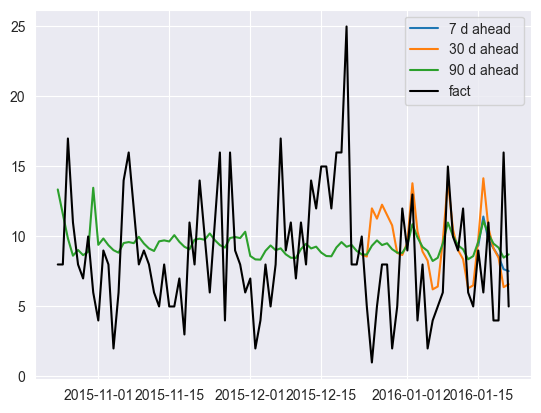

    mapes_mean  mapes_median  smapes_mean
5    64.487519     52.115098    48.564215
30  105.085884     37.965427    46.682850
90   67.624918     36.039077    42.495169


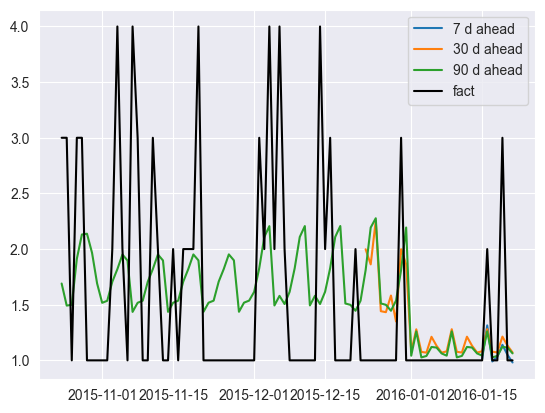

    mapes_mean  mapes_median  smapes_mean
5    15.548915      3.170078    20.521612
30   31.155144     17.211849    26.341411
90   46.530141     49.386376    39.999956


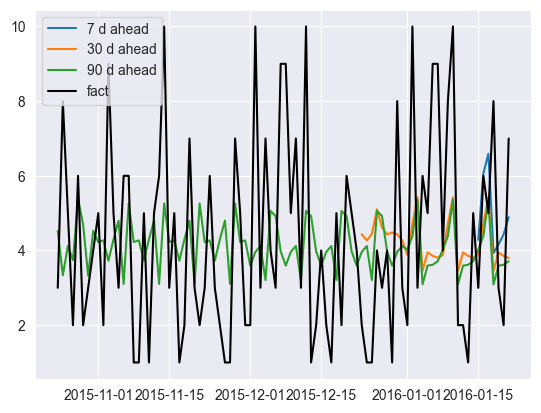

    mapes_mean  mapes_median  smapes_mean
5    45.259432     38.791323    39.345783
30   86.030099     49.272158    57.278616
90   82.211298     48.915851    55.002375


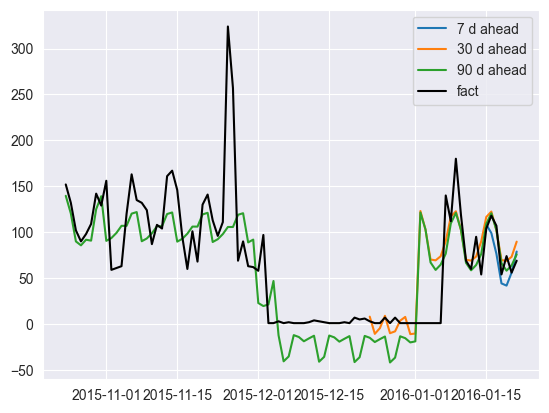

     mapes_mean  mapes_median  smapes_mean
5     17.805846     16.005488    20.508043
30  1674.410227     51.084614    95.241732
90  1009.554761     52.161903    94.038224


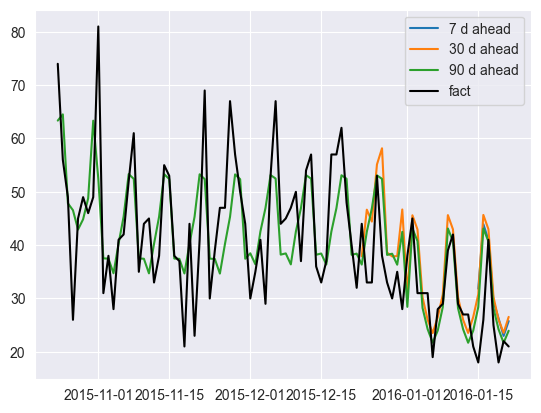

    mapes_mean  mapes_median  smapes_mean
5    33.849655     22.713787    26.490899
30   23.171423     16.995635    19.649906
90   18.287300     14.368275    16.820293


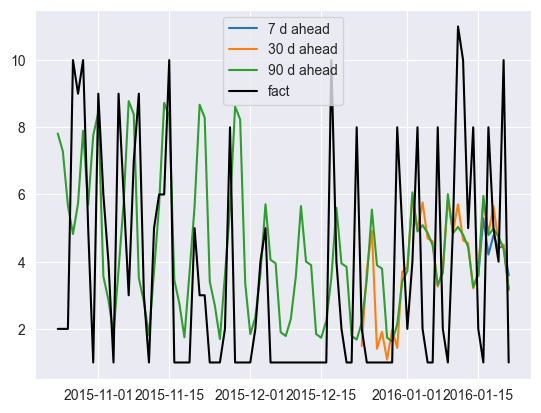

    mapes_mean  mapes_median  smapes_mean
5   126.206585     55.143202    65.385426
30  128.068203     59.610818    69.935925
90  147.218264     79.040406    72.339606


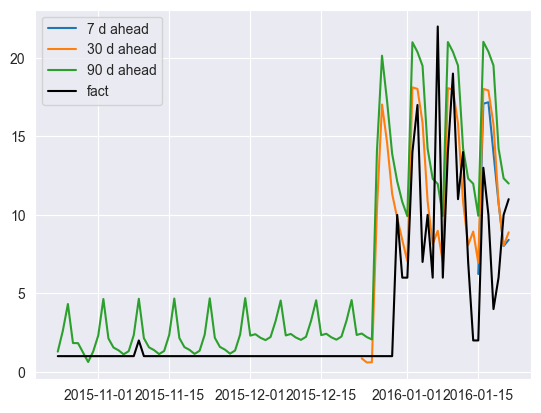

    mapes_mean  mapes_median  smapes_mean
5    97.988690     71.736510    57.023705
30  220.405030     38.884149    58.337941
90  187.065546    113.394161    70.680746


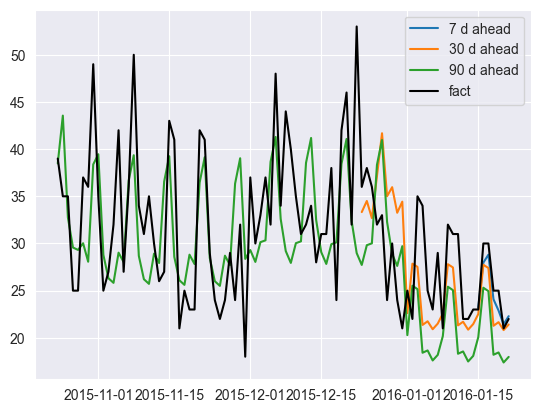

    mapes_mean  mapes_median  smapes_mean
5     3.887992      3.659254     3.991060
30   16.854787     12.209648    16.481463
90   18.707753     18.569103    19.479420


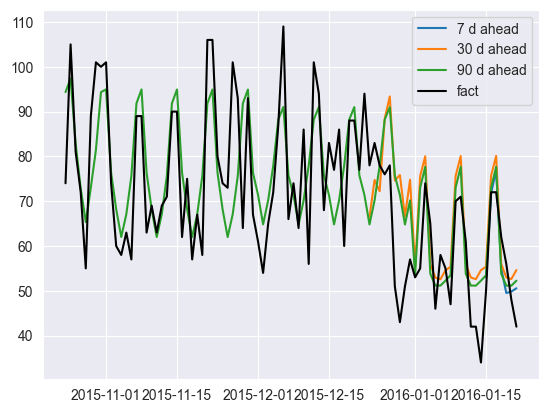

    mapes_mean  mapes_median  smapes_mean
5     8.629503      6.903578     8.491395
30   19.410679     13.347878    17.007348
90   13.959972     11.598705    13.198692


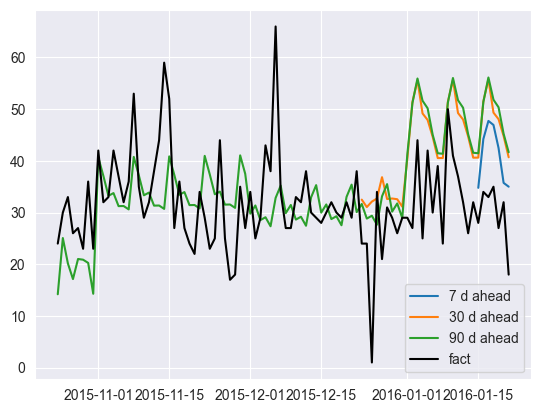

    mapes_mean  mapes_median  smapes_mean
5    42.376815     34.137789    33.316015
30  145.594955     39.798189    38.284250
90   61.257644     22.823751    28.472007


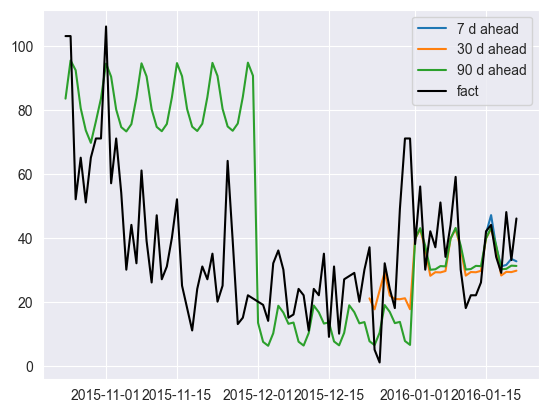

    mapes_mean  mapes_median  smapes_mean
5    12.750847      7.041791    14.358462
30  108.104815     22.963251    39.101200
90   96.734194     44.447440    59.579367


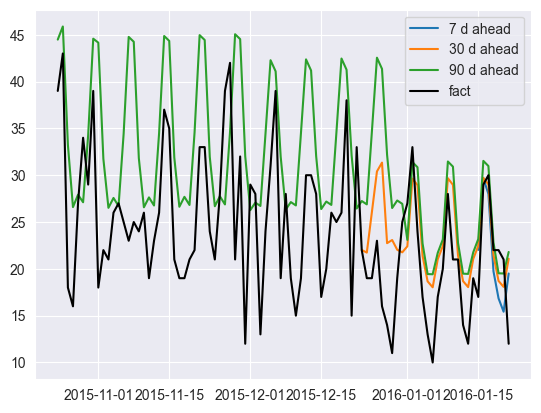

    mapes_mean  mapes_median  smapes_mean
5    23.043744     23.423677    21.508745
30   29.994895     18.788728    24.068361
90   42.120975     34.155682    31.611699


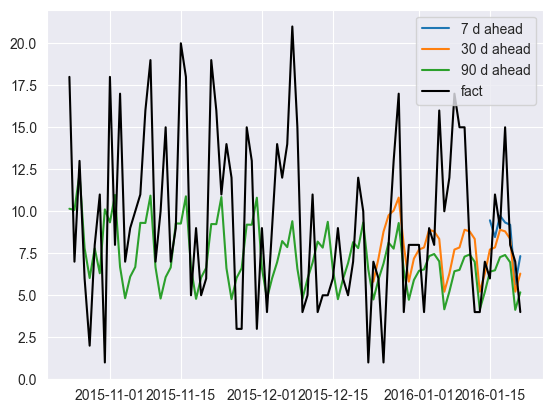

    mapes_mean  mapes_median  smapes_mean
5    34.931213     23.042955    31.374836
30   59.219551     28.678008    38.582768
90   62.873932     39.842721    46.700073


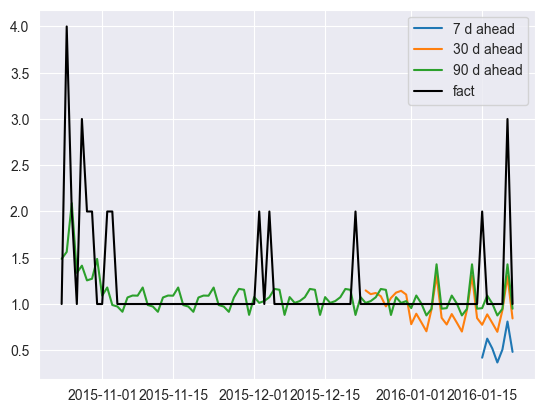

    mapes_mean  mapes_median  smapes_mean
5    57.386975     51.767635    83.205422
30   18.734547     14.803597    21.078792
90   14.899697      8.977611    16.281251


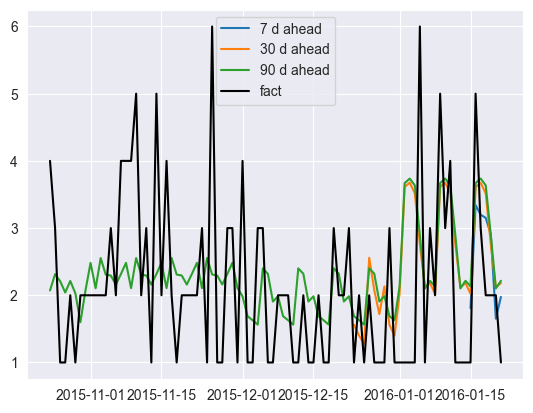

    mapes_mean  mapes_median  smapes_mean
5    48.351632     45.343380    38.577449
30   81.967797     55.055331    53.245183
90   61.995510     46.120303    45.694387


In [79]:
for name in tsp.items_names:
    tsp.run_pipeline_boost(name)

Вывод
Prophet + бустинг гораздо лучше себя показывают, чем классические модели. В целом, на картинках видно, как модель угадывает неочевидные дрифты трендов, достаточно хорошо моделирует сезонность. 